# Análisis de la de los resultados de la minería de reglas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import seaborn as sns
import numpy as np
import networkx as nx
from matplotlib.patches import Patch

# Análisis de las reglas generadas

In [ ]:
# Cargar dataset de reglas filtradas y etiquetas de parámetros bioquímicos

df_diagnosticos_reglas = pd.read_parquet("/data/reglas_diagnostico_filtradas_5antecedent.parquet")
df_labitems = pd.read_csv("/data/d_labitems.csv")

df_diagnosticos_reglas.head()

,antecedent,consequent,confidence,lift,support,num_antecedents
0,"[50862, 50983, 50902, 51006, 51279]",[E87],0.721222,3.202928,0.056165,5
1,"[50821, 50971, 51237, 51006, 51279]",[E87],0.702468,3.119645,0.053528,5
2,"[I13, I50, 51249, 51279]",[N18],0.994378,5.055215,0.055021,4
3,"[50820, 50983, 52172, 51221, 51222]",[E87],0.710830,3.156776,0.053437,5
4,"[I48, E78, 52172, 51221, 50931]",[Z79],0.730888,2.212145,0.052073,5


In [ ]:
print(df_diagnosticos_reglas.dtypes)

antecedent          object
consequent          object
confidence         float64
lift               float64
support            float64
num_antecedents      int32
dtype: object


In [ ]:
print(type(df_diagnosticos_reglas["antecedent"].iloc[0]))

<class 'numpy.ndarray'>


In [ ]:
# Convertir las columnas de arrays de NumPy a listas de Python
df_diagnosticos_reglas["antecedent"] = df_diagnosticos_reglas["antecedent"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df_diagnosticos_reglas["consequent"] = df_diagnosticos_reglas["consequent"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

print(type(df_diagnosticos_reglas["antecedent"].iloc[0]))  # Debería mostrar <class 'list'>
print(type(df_diagnosticos_reglas["consequent"].iloc[0]))  # Debería mostrar <class 'list'>

<class 'list'>
<class 'list'>


In [ ]:
# Frecuencia diagnósticos en el consecuente
consequent_counts = df_diagnosticos_reglas["consequent"].apply(lambda x: x[0] if len(x) > 0 else None).value_counts()
print(consequent_counts)

consequent
E87    3266
Z79    1840
N18     822
I25     670
N17     425
I50     397
E78     345
Z68     166
I13     141
I48      48
Y92      32
E66       3
Name: count, dtype: int64


In [ ]:
# Contar el número de reglas generadas
num_rules_filtradas = df_diagnosticos_reglas.count()

print(f"El modelo generó un total de {num_rules_filtradas} reglas con diagnostico como consecuente.")

El modelo generó un total de antecedent         8155
consequent         8155
confidence         8155
lift               8155
support            8155
num_antecedents    8155
dtype: int64 reglas con diagnostico como consecuente.


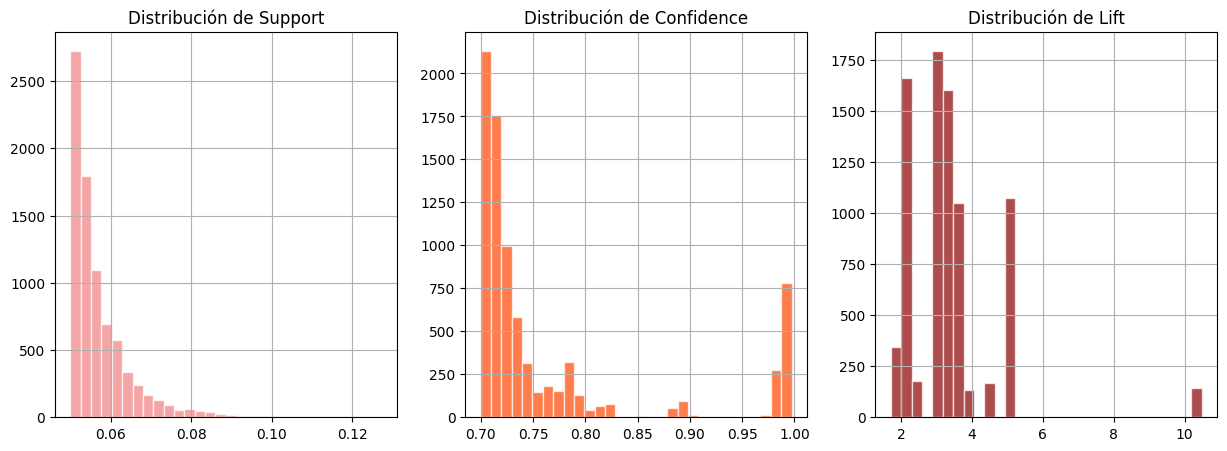

In [ ]:
# Histogramas con la distribución de las métricas que evaluan las reglas de asociación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Soporte
df_diagnosticos_reglas["support"].hist(ax=axes[0], bins=30, color="lightcoral", alpha=0.7, edgecolor="white")
axes[0].set_title("Distribución de Support")

# Confianza
df_diagnosticos_reglas["confidence"].hist(ax=axes[1], bins=30, color="orangered", alpha=0.7, edgecolor="white")
axes[1].set_title("Distribución de Confidence")

# Lift
df_diagnosticos_reglas["lift"].hist(ax=axes[2], bins=30, color="darkred", alpha=0.7, edgecolor="white")
axes[2].set_title("Distribución de Lift")

plt.show()

## Reglas con el lift más alto (mayor de 10)

In [ ]:
# Filtrar reglas con lift mayor de 10
df_filtrado_lift10 = df_diagnosticos_reglas[
    (df_diagnosticos_reglas['lift'] > 10)
]

df_filtrado_lift10.head()

,antecedent,consequent,confidence,lift,support,num_antecedents
82,"[I50, N18, 51249, 51221, 51279]",[I13],0.784335,10.395718,0.052671,5
173,"[I50, N18, 51249, 51221]",[I13],0.784958,10.403983,0.053949,4
292,"[I50, N18, 51006, 51221, 0]",[I13],0.783988,10.391121,0.059146,5
321,"[I50, N18, 50912, 51006, 51221]",[I13],0.784452,10.397277,0.060563,5
334,"[I50, N18, 51006, 51221]",[I13],0.783163,10.380192,0.063181,4


In [ ]:
# Función para extraer los parámetros bioquímicos (items de 5 dígitos)
def extract_bioquimicos(antecedent):
    return [item for item in antecedent if item.isdigit() and len(item) == 5]

df_diagnosticos_reglas["bioquimicos"] = df_diagnosticos_reglas["antecedent"].apply(extract_bioquimicos)

print(df_diagnosticos_reglas["bioquimicos"].head())

0    [50862, 50983, 50902, 51006, 51279]
1    [50821, 50971, 51237, 51006, 51279]
2                         [51249, 51279]
3    [50820, 50983, 52172, 51221, 51222]
4                  [52172, 51221, 50931]
Name: bioquimicos, dtype: object


In [ ]:
# Expandir la columna 'bioquimicos' para que cada parámetro tenga su propia fila
df_bioquimicos_exploded = df_diagnosticos_reglas.explode("bioquimicos")

# Contar la frecuencia de cada parámetro bioquímico
conteo_bioquimicos = df_bioquimicos_exploded["bioquimicos"].value_counts().reset_index()
conteo_bioquimicos.columns = ["Parametro_Bioquimico", "Frecuencia"]

# Convertir la columna a numérico para hacer merge
conteo_bioquimicos["Parametro_Bioquimico"] = pd.to_numeric(conteo_bioquimicos["Parametro_Bioquimico"], errors="coerce")

In [ ]:
# Añadir las etiquetas a conteo_bioquimicos
conteo_bioquimicos_merged = conteo_bioquimicos.merge(
    df_labitems[['itemid', 'label']],
    left_on="Parametro_Bioquimico",
    right_on="itemid",
    how="left"
)

conteo_bioquimicos_merged = conteo_bioquimicos_merged.drop(columns=['itemid'])

In [ ]:
conteo_bioquimicos_merged.head()

,Parametro_Bioquimico,Frecuencia,label
0,50931,2135,Glucose
1,51222,2133,Hemoglobin
2,51279,2099,Red Blood Cells
3,51006,2012,Urea Nitrogen
4,51221,1994,Hematocrit


## Reglas con el lift bajo

In [ ]:
# Filtrar reglas con lift entre 2 y 3
df_filtrado2_3 = df_diagnosticos_reglas[
    (df_diagnosticos_reglas['lift'].between(2, 3))
]

df_filtrado2_3.head()

,antecedent,consequent,confidence,lift,support,num_antecedents,bioquimicos
4,"[I48, E78, 52172, 51221, 50931]",[Z79],0.730888,2.212145,0.052073,5,"[52172, 51221, 50931]"
7,"[N18, E11, 51222, 0]",[Z79],0.718541,2.174774,0.062119,4,[51222]
17,"[I50, E11, 51222, 0]",[Z79],0.748272,2.264759,0.056466,4,[51222]
19,"[I48, 51274, 51249, 52172, 51279]",[Z79],0.730573,2.211192,0.061736,5,"[51274, 51249, 52172, 51279]"
20,"[I48, 51274, 51237, 51279]",[Z79],0.721876,2.184869,0.089801,4,"[51274, 51237, 51279]"


In [ ]:
df_filtrado2_3 = df_filtrado2_3.copy()

# Aplicar la función y expandir la columna de parámetros bioquímicos
df_filtrado2_3["bioquimicos"] = df_filtrado2_3["antecedent"].apply(extract_bioquimicos)
df_bioquimicos_exploded2_3 = df_filtrado2_3.explode("bioquimicos")

# Contar la frecuencia y realizar el merge con df_labitems
conteo_bioquimicos2_3 = df_bioquimicos_exploded2_3["bioquimicos"].value_counts().reset_index()
conteo_bioquimicos2_3.columns = ["Parametro_Bioquimico", "Frecuencia"]

conteo_bioquimicos2_3["Parametro_Bioquimico"] = pd.to_numeric(conteo_bioquimicos2_3["Parametro_Bioquimico"], errors="coerce")
conteo_bioquimicos_merged2_3 = conteo_bioquimicos.merge(df_labitems[['itemid', 'label']],
                                                      left_on="Parametro_Bioquimico",
                                                      right_on="itemid",
                                                      how="left")

conteo_bioquimicos_merged2_3 = conteo_bioquimicos_merged2_3.drop(columns=['itemid'])

conteo_bioquimicos_merged2_3.head()

,Parametro_Bioquimico,Frecuencia,label
0,50931,2135,Glucose
1,51222,2133,Hemoglobin
2,51279,2099,Red Blood Cells
3,51006,2012,Urea Nitrogen
4,51221,1994,Hematocrit


In [ ]:
# Filtrar reglas con lift entre 1,7 y 2
df_filtrado_menos2 = df_diagnosticos_reglas[
    (df_diagnosticos_reglas['lift'].between(1.7, 2))
]

df_filtrado_menos2.head()

,antecedent,consequent,confidence,lift,support,num_antecedents,bioquimicos
18,"[Z95, I25, Medicare, 0]",[E78],0.731356,1.786296,0.059467,4,[]
27,"[I25, Z79, 51221, 51222]",[E78],0.702085,1.714803,0.071408,4,"[51221, 51222]"
29,"[I25, K21]",[E78],0.728073,1.778278,0.051489,2,[]
75,"[Z95, I25, M]",[E78],0.723157,1.766272,0.058409,3,[]
99,"[I25, MARRIED, 51221, 51279]",[E78],0.709996,1.734127,0.063262,4,"[51221, 51279]"


In [ ]:
df_filtrado_menos2 = df_filtrado_menos2.copy()

# Aplicar la función y expandir la columna de parámetros bioquímicos
df_filtrado_menos2["bioquimicos"] = df_filtrado_menos2["antecedent"].apply(extract_bioquimicos)
df_bioquimicos_exploded_menos2 = df_filtrado_menos2.explode("bioquimicos")

# Contar la frecuencia y realizar el merge con df_labitems
conteo_bioquimicos_menos2 = df_bioquimicos_exploded_menos2["bioquimicos"].value_counts().reset_index()
conteo_bioquimicos_menos2.columns = ["Parametro_Bioquimico", "Frecuencia"]

conteo_bioquimicos_menos2["Parametro_Bioquimico"] = pd.to_numeric(conteo_bioquimicos_menos2["Parametro_Bioquimico"], errors="coerce")
conteo_bioquimicos_merged_menos2 = conteo_bioquimicos.merge(df_labitems[['itemid', 'label']],
                                                      left_on="Parametro_Bioquimico",
                                                      right_on="itemid",
                                                      how="left")

conteo_bioquimicos_merged_menos2 = conteo_bioquimicos_merged_menos2.drop(columns=['itemid'])

conteo_bioquimicos_merged_menos2.head()

,Parametro_Bioquimico,Frecuencia,label
0,50931,2135,Glucose
1,51222,2133,Hemoglobin
2,51279,2099,Red Blood Cells
3,51006,2012,Urea Nitrogen
4,51221,1994,Hematocrit


# Visualización gráfica de las conclusiones

In [ ]:
# Funcion que categoriza los antecedentes en 3 categorías:
#   bioquimicos: parámetros bioquimicos alterados (5 dígitos)
#   diagnosticos: diagnósticos médicos (letra + 2 dígitos)
#   otros: restos de variables sociodemográficas que aparecen en las reglas

def categorizar_antecedentes(antecedent):
    if isinstance(antecedent, list):
        bioquimicos = [item for item in antecedent if item.isdigit() and len(item) == 5]                # Números de 5 dígitos
        diagnosticos = [item for item in antecedent if re.match(r"^[A-Za-z]\d{2}$", item)]              # Diagnósticos (Letra + 2 dígitos)
        otros = [item for item in antecedent if item not in bioquimicos and item not in diagnosticos]   # Otras variables
        return bioquimicos, diagnosticos, otros
    return [], [], []  # Si no es una lista, devolver listas vacías


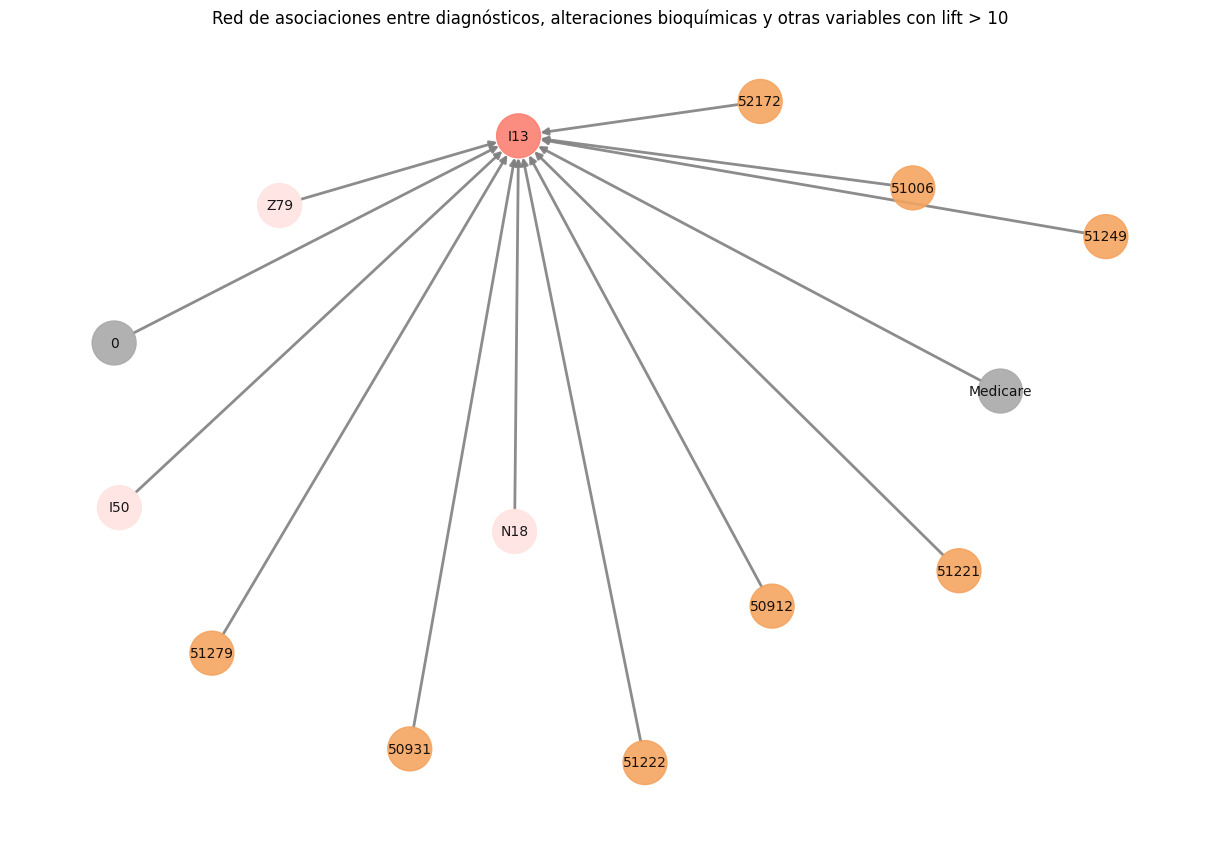

In [ ]:
df_filtrado_lift10 = df_filtrado_lift10.copy()

# Aplicar función categorizar_antecedentes para lift mayor de 10
df_filtrado_lift10["bioquimicos"], df_filtrado_lift10["diagnosticos"], df_filtrado_lift10["otros"] = zip(
    *df_filtrado_lift10["antecedent"].apply(categorizar_antecedentes)
)

# Crear el grafo
G = nx.DiGraph()

# Iterar sobre las reglas y añadir nodos y aristas
for _, row in df_filtrado_lift10.iterrows():
    # Convertir el consecuente en string si es una lista
    consecuente = row["consequent"][0] if isinstance(row["consequent"], list) and len(row["consequent"]) > 0 else str(row["consequent"])

    bioquimicos = row["bioquimicos"]
    diagnosticos = row["diagnosticos"]
    otros = row["otros"]

    # Añadir nodos con colores diferenciados
    for b in bioquimicos:
        G.add_node(b, color="sandybrown")

    for d in diagnosticos:
        G.add_node(d, color="mistyrose")

    for o in otros:
        G.add_node(o, color="darkgrey")

    # Nodo del consecuente
    G.add_node(consecuente, color="salmon")

    # Crear aristas hacia el consecuente
    for b in bioquimicos:
        G.add_edge(b, consecuente)

    for d in diagnosticos:
        G.add_edge(d, consecuente)

    for o in otros:
        G.add_edge(o, consecuente)

# Dibujar el grafo
plt.figure(figsize=(12, 8))
colors = [G.nodes[node]["color"] for node in G.nodes]
pos = nx.spring_layout(G, k=0.7)

nx.draw(G, pos, with_labels=True, node_color=colors, edge_color="gray", node_size=1000, font_size=10, alpha=0.9, width=2)
plt.title("Red de asociaciones entre diagnósticos, alteraciones bioquímicas y otras variables con lift > 10")
plt.show()

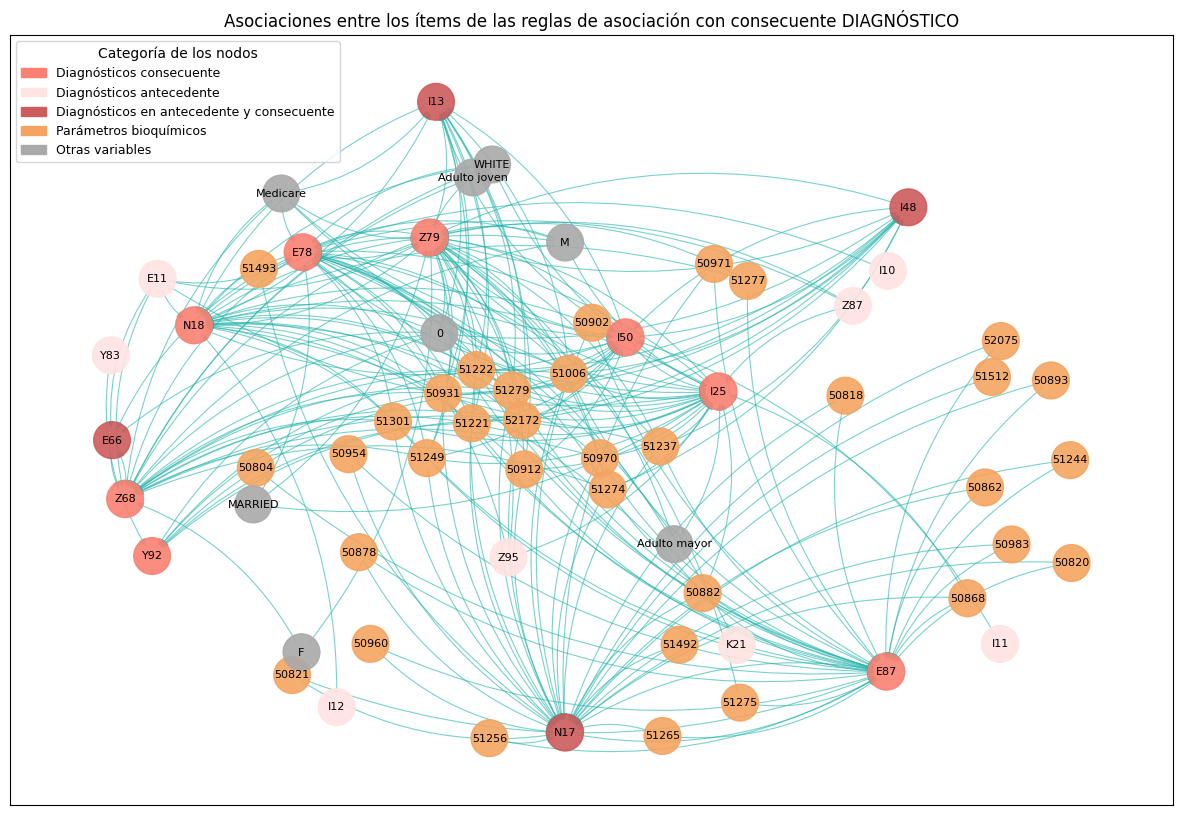

In [ ]:
# Aplicar función categorizar_antecedentes para todos los diagnósticos
df_diagnosticos_reglas["bioquimicos"], df_diagnosticos_reglas["diagnosticos"], df_diagnosticos_reglas["otros"] = zip(
    *df_diagnosticos_reglas["antecedent"].apply(categorizar_antecedentes)
)

# Obtener lista de diagnósticos que aparecen como consecuentes
diagnosticos_consecuente = set(df_diagnosticos_reglas["consequent"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else str(x)))

# Crear el grafo
G = nx.DiGraph()

# Iterar sobre las reglas y añadir nodos y aristas
for _, row in df_diagnosticos_reglas.iterrows():
    # Convertir el consecuente en string si es una lista
    consecuente = row["consequent"][0] if isinstance(row["consequent"], list) and len(row["consequent"]) > 0 else str(row["consequent"])

    bioquimicos = row["bioquimicos"]
    diagnosticos = row["diagnosticos"]
    otros = row["otros"]

    # Añadir nodos con colores diferenciados
    for b in bioquimicos:
        G.add_node(b, color="sandybrown")

    for d in diagnosticos:
        if d in diagnosticos_consecuente:
            G.add_node(d, color="indianred")
        else:
            G.add_node(d, color="mistyrose")

    for o in otros:
        G.add_node(o, color="darkgrey")

    # Nodo del consecuente
    G.add_node(consecuente, color="salmon")

    # Crear aristas hacia el consecuente
    for b in bioquimicos:
        G.add_edge(b, consecuente)

    for d in diagnosticos:
        G.add_edge(d, consecuente)

    for o in otros:
        G.add_edge(o, consecuente)

# Dibujar el grafo
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1)

# Obtener colores de los nodos
colors = [G.nodes[node]["color"] for node in G.nodes]

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=700, alpha=0.9)

# Dibujar etiquetas
nx.draw_networkx_labels(G, pos, font_size=8)

# Dibujar aristas
edges = nx.draw_networkx_edges(
    G, pos, edge_color="lightseagreen", alpha=0.6, width=0.8,
    connectionstyle="arc3,rad=0.2")

# Leyenda
legend_patches = [
    Patch(color="salmon", label="Diagnósticos consecuente"),
    Patch(color="mistyrose", label="Diagnósticos antecedente"),
    Patch(color="indianred", label="Diagnósticos en antecedente y consecuente"),
    Patch(color="sandybrown", label="Parámetros bioquímicos"),
    Patch(color="darkgrey", label="Otras variables")
]

plt.legend(handles=legend_patches, loc="upper left", title="Categoría de los nodos", fontsize=9)

plt.title("Asociaciones entre los ítems de las reglas de asociación con consecuente DIAGNÓSTICO")
plt.show()

<ipython-input-71-f38a231b1f69>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


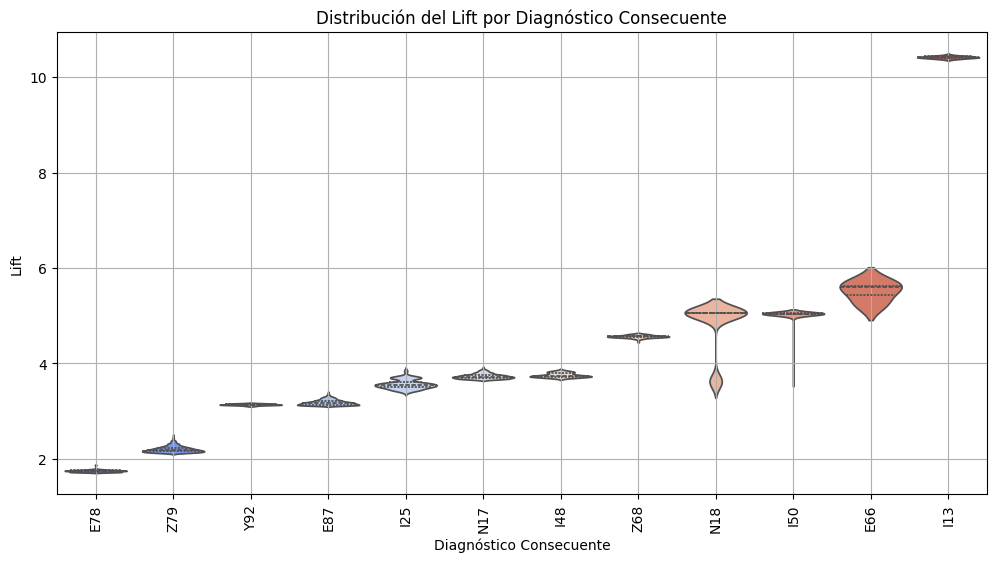

In [ ]:
df_diagnosticos_reglas_copy = df_diagnosticos_reglas.copy()
df_diagnosticos_reglas_copy["consequent"] = df_diagnosticos_reglas_copy["consequent"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else str(x))

# Ordenar diagnósticos por lift promedio
mean_lift_per_consequent = df_diagnosticos_reglas_copy.groupby("consequent")["lift"].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_diagnosticos_reglas_copy,
    x="consequent",
    y="lift",
    order=mean_lift_per_consequent.index,
    palette="coolwarm",
    inner="quartile"
)

plt.xticks(rotation=90)
plt.xlabel("Diagnóstico Consecuente")
plt.ylabel("Lift")
plt.title("Distribución del Lift por Diagnóstico Consecuente")
plt.grid(True)

plt.show()

El análisis de la distribución del lift por diagnóstico consecuente revela que cada diagnóstico presenta un rango característico de lift, lo que indica que las reglas con el mismo consecuente tienden a agruparse en torno a valores similares.
Diagnósticos como E78, Z79 y Y92 muestran lifts bajos y homogéneos, mientras que otros, como I50 y N18, presentan mayor variabilidad, sugiriendo la existencia de subgrupos con diferentes niveles de asociación.
En contraste, diagnósticos como I13 exhiben un lift consistentemente alto (>10), lo que evidencia asociaciones excepcionalmente fuertes con sus antecedentes.


<ipython-input-72-7cb336bfd110>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Diagnóstico")


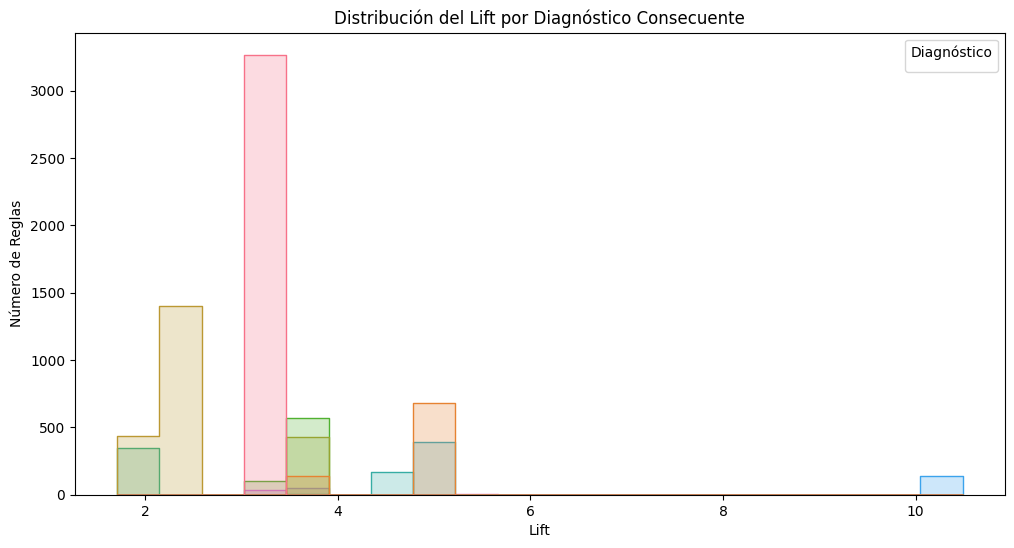

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_diagnosticos_reglas_copy, x="lift", hue="consequent", bins=20, element="step", stat="count", common_norm=False)
plt.xlabel("Lift")
plt.ylabel("Número de Reglas")
plt.title("Distribución del Lift por Diagnóstico Consecuente")
plt.legend(title="Diagnóstico")
plt.show()